##Implementing R-CNN for object detection on a custom dataset



## 1.Downloading the dataset

In [1]:
!pip install -q --upgrade selectivesearch torch_snippets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.5 MB/s eta 0:00:00


In [2]:
from torch_snippets import*
import selectivesearch

from google.colab import files
files.upload()
!mkdir -p ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/ .kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

from torchvision import transforms, models, datasets
from torch_snippets.torch_loader import Report
from torchvision.ops import nms
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

Saving kaggle.json to kaggle.json
chmod: cannot access '.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks/versions/
License(s): unknown
 99% 362M/367M [00:04<00:00, 98.6MB/s]
100% 367M/367M [00:04<00:00, 87.9MB/s]


##2.Preparing the dataset

Now that we have downloaded the dataset, we will prepare the dataset. This involves the following steps:
1. Fetching each image and it's corresponding class and bounding box values

2. Fetching the region proposals within each image, their corresponding IoU, and the delta by which the region proposal is to be corrected with respect to the ground truth.

3. Assigning numeric labels for each class (where we have an additional background class (besides the bus and truck classes) where IoU with the ground truth bounding box is below threshold)

4. Resizing each region proposal to a common size inorder to pass them to a network

###2.1Specify the location of images and read the ground truths present inthe csv file

In [3]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

Note that `XMin`, `XMax`, `YMin` and `YMax` correspond to the ground truth of the bounding box of the image. Further more, `LabelName` provides the class of the image.

###2.2 Define a class that returns the image and it's corresponding class and ground truth along with the file path of the image

* Pass the data frame `(df)` and the path to the foder containing images `(image_folder)` as input to the `__init__` method and fetch the unique `ImageID` values present in the data frame (`self.unique_images`). We do so , as an image can contain a multiple number of objects and so multiple rows can correspond to same `ImageID` value.

* Define the `__getitem__` method, where we fetch the image (`image_id`) corresponding to an index(`ix`), fetch its bounding box co-ordinates (`boxes`), `classes`, and return the image, bounding box, class, and image path.

In [4]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
import cv2


class OpenImages(Dataset):
  def __init__(self, df, image_folder=IMAGE_ROOT):
    self.root = image_folder
    self.df = df
    self.unique_images = df['ImageID'].unique()

  def __len__(self): return len(self.unique_images)

  def __getitem__(self, ix):
    image_id = self.unique_images[ix]
    image_path = f'{self.root}/{image_id}.jpg'
    image = cv2.imread(image_path, 1)[...,::-1] # convert BGR to RGB

    # Convert the image to an unsigned 8-bit integer format if it isn't already
    image = img_as_ubyte(image)

    h, w, _ = image.shape
    df = self.df.copy()
    df = df[df['ImageID'] == image_id]
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
    classes = df['LabelName'].values.tolist()
    return image, boxes, classes, image_path




##3.Inspect a sample image and it's corresponding class and bounding box ground truth

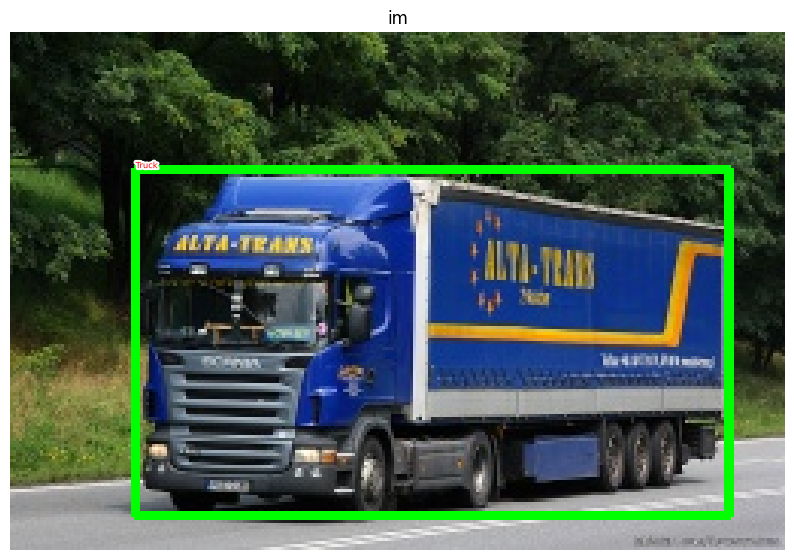

In [5]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

##4.Define the `extract_iou` and `extract_candidates` funtions

In [6]:
from skimage import img_as_ubyte

def extract_candidates(img):
  # Ensure the image is in an unsigned byte format
  img = img_as_ubyte(img)

  img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = []

  for r in regions:
    if r[r'rect'] in candidates: continue
    if r['size'] < (0.05 * img_area): continue
    if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))

  return candidates


def extract_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])

  width = (x2 - x1)
  height = (y2 - y1)

  if (width<0) or (height<0):
    return 0.0

  area_overlap = width* height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined + epsilon)

  return iou

##5.Fetching region proposals and the ground truth offset

In this section, we will learn about creating the input and output values corresponding to our model. The input constitutes the candidates that are extracted using the `selectivesearch` method and the output constitutes the class corresponding to candidates and the offset of the candidate with respect to the bounding box it overlaps the most with if the candidate contains an object.

STEP 1

1. Initialize empty lists to store file paths (`FPATHS`), ground truth bounding boxes (`GTBBS`), classes (`CLSS`) of objects, the data offset of a bounding box with region proposals (`DELTAS`), region proposal locations (`ROIS`), and the IoU of the region proposals with ground truths (`IOUS`).

STEP 2

2. Loop through the dataset and populate the lists initialized in the previous section.

  STEP 2.1
  * For this, we can use all the data points for training or illustrate with just the first 500 data points. You can choose between either of the two, which dictates the training time and training accuracy (the greater the data points, the greater the training time and accuracy)

  STEP 2.2
  * Next, extract candidates from each image (`im`) in absolute pixel values (note that `XMin`, `Xmax`, `YMin` and `YMax` are available as a porportion of the shape of images in the downloaded data frame) using the `extract_candidates` function and convert the extracted regions coordinates from an (x,y,w,h) system to an (x,y,x+w,y+h) system.

  STEP 2.3
  * Initialize `ious`,`rois`,`deltas` and `clss` as lists that store `iou` for each candidate, region proposal location, bounding box offset, and class corresponding to every candidate for each image. We will go through all the proposals from SelectiveSearch and store those with a high IOU as bus/truck proposals (whichever is the class in labels) and the rest as background proposals.

  STEP 2.4
  * Store the IoU of all candidates with respect to all ground truths for an image where `bbs` is the ground truth bounding box of different objects present in the image and `candidates` are the region proposal candidates obtained in the previous step.

  STEP 2.5
  * Loop through each candidate and store the XMin(`cx`), YMin(`cy`), XMax(`cx`), and YMax(`cy`) values of a candidate.

  STEP 2.6
  * Extract the IoU corresponding to the candidate with respect to all the ground truth bounding boxes that were already calculated when fetching the list of lists of `ious`.

  STEP 2.7
  * Find the index of a candidate (`best_iou_at`) that has the highest IoU and the corresponding grond truth (`best_bb`)

  STEP 2.8
  * If IoU (`best_iou`) is greater than a threshold (`0.3`), we assign the label of class corresponding to the candidate, and the background otherwise.

  STEP 2.9
  * Fetch the offsets needed (`delta`) to transform the current proposal into the candidate that is the best region proposal (which is the ground truth bounding box) -`best_bb`, in other words, how much should the left, right, top, and bottom margins of the current proposal be adjusted so that it aligns exactly with `best_bb` from the ground truth.

  STEP 2.10
  * Appending the file paths, IoU, roi, class delta, and ground truth bounding boxes.

  STEP 2.11
  * Fetch the image path names and store all the information obtained, `FPATHS`, `IOUS`, `ROIS`, `CLSS`, `DELTAS`, and `GTBBS`, in a list of lists.


  Note that so far, classes are available as the name of the class. We will convert them into their corresponding indices so that a background class has a class index of 0, a bus class has a class index of 1, and a truck class has a class index of 2.


STEP 3
3. Assign indices to each class



In [7]:
# step 1
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

### step 2  ###
N = 500

# step 2.1
for ix, (im, bbs, labels, fpath) in enumerate(ds):
  if (ix == N): break

  # step 2.2
  H, W, _ = im.shape
  candidates = extract_candidates(im)
  candidates = np.array([(x, y, x+w, y+h) for x, y, w, h in candidates])

  # step 2.3
  ious, rois, clss, deltas = [], [], [], []

  # step 2.4
  ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

  # step 2.5
  for jx, candidate in enumerate(candidates):
    cx, cy, cX, cY = candidate

    #step 2.6
    candidate_ious = ious[jx]

    #step 2.7
    best_iou_at = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_at]
    best_bb = _x, _y, _X, _Y = bbs[best_iou_at]

    #step 2.8
    if best_iou > 0.3: clss.append(labels[best_iou_at])
    else: clss.append('background')

    #step 2.9
    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(candidate / np.array([W, H, W, H]))

  #step 2.10
  FPATHS.append(fpath)
  IOUS.append(ious)
  ROIS.append(rois)
  CLSS.append(clss)
  DELTAS.append(deltas)
  GTBBS.append(bbs)

#step 2.11
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [8]:
# step 3

targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l  in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

##6.Creating the training data

So far, we have fetched data, region proposals across all images, prepared the ground truths of the class of object present within each region proposal, and the offset corresponding to each region proposal that has a high overlap (IoU) with the object in the corresponding image.

We will prepare a dataset class based on the ground truth of region proposals that are obtained by the end of the previous step and create data loaders from it. Next, we'll normalize each region proposal by resizing them to the same shape and scaling them.

###6.1 Define the function to normalize an image

In [9]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

###6.2 Define a function (`preprocess_image`) to preprocess the image (`img`), where we switch channels, normalize the images, and register it with the device

In [33]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2, 0, 1)
  img = normalize(img)
  return img.to(device)

# Define the function to the class `decode` prediction
def decode(_y):
  _, preds = _y.max(-1)
  return preds

###6.3 Define the dataset (`RCNNDataset`) using the preprocessed region proposals along with the ground truths obtained in the previous step.


In [46]:
from torch.utils.data import Dataset
import numpy as np

class RCNNDataset(Dataset):
  def __init__(self, fpaths, rois, labels, deltas, gtbbs):
    self.fpaths = fpaths
    self.gtbbs = gtbbs
    self.rois = rois
    self.labels = labels
    self.deltas = deltas

  def __len__(self): return len(self.fpaths)

  # Fetch the crops as per the region proposals, along with the other ground
  # truths related to class and the bounding box offset
  def __getitem__(self, ix):
    fpath = str(self.fpaths[ix])
    image = cv2.imread(fpath, 1)[..., ::-1]
    H, W, _ = image.shape
    sh = np.array([W,H,W,H])
    gtbbs = self.gtbbs[ix]
    rois = self.rois[ix]
    bbs = (np.array(rois)*sh).astype(np.uint16)
    labels = self.labels[ix]
    deltas = self.deltas[ix]
    crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
    return image, crops, bbs, labels, deltas, gtbbs, fpath

  # Define collate_fn, which performs the resizing and normalizing (preproces_image)
  # of an image of a crop
  def collate_fn(self, batch):
    input, rois, rixs, labels, deltas = [], [], [], [], []
    for ix in range(len(batch)):
      image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
      crops = [cv2.resize(crop, (224, 224)) for crop in crops]
      crops = [preprocess_image(crop/255.)[None] for crop in crops]
      input.extend(crops)
      deltas.extend(image_deltas)

    input = torch.cat(input).to(device)
    labels = torch.Tensor(labels).long().to(device)
    deltas = torch.Tensor(deltas).float().to(device)
    return input, labels, deltas




###6.4 Create the training and validation datasets and dataloaders

In [47]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train],DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

# Creating the dataloaders
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

So far, we have leaned about preparing data. Next, we'll learn about defining and training the model that predicts the class and offsets to be made to the region proposal to fit a tight bounding box around objects in the image.

##7.R-CNN network architecture

Now that we have prepared the data, in this section, we will learn about building a model that can predict both the class of region proposal and the offset corresponding to it in order to draw a tight bounding box around the object in the image. The strategy we adopt is as follows:

1. Define a VGG backbone

2. Fetch the features post passing the normalized crop through a pretrained model.

3. Attach a linear layer with sigmoid activation to the VGG backbone to predict the class corresponding to the region proposal.

4. Attach an additional linear layer to predict the four bounding box offsets.

5. Define the loss calcualtions for each of the two outputs (one to predict class and the other to predict the four bounding box offsets).

6. Train the model that predicts both the class of the region proposal and four bounding box offsets.

###7.1 Define a VGG backbone


In [48]:
from torchvision import models

weights = models.VGG16_Weights.DEFAULT
vgg_backbone = models.vgg16(weights=weights)

for param in vgg_backbone.parameters():
  param.requires_grad = False

vgg_backbone.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###7.2 Define the `R-CNN` network module

In [58]:
# from torch import nn


# class RCNN(nn.Module):
#   def __init__(self):
#     super().__init__()

#     # Define the backbone (self.backbone) and how we calculate the class score(self.cls_score)
#     # and the bounding box offset values (self.bbox)

#     feature_dim = 25088
#     self.backbone = vgg_backbone
#     self.cls_score = nn.Linear(feature_dim, len(label2target))
#     self.bbox = nn.Sequential(
#       nn.Linear(feature_dim, 512),
#       nn.ReLU(),
#       nn.Linear(512, 4),
#       nn.Tanh(),
#     )

#     # Define the loss functions corresponding to class prediction (self.cel) and
#     # boundng box offset regression (self.sl1)

#     self.cel = nn.CrossEntropyLoss()
#     self.sl1 = nn.L1Loss()

#   # Define the feed-forward method
#   def forward(self, input):

#     # pass image through a VGG backbone to fetch features
#     feat = self.backbone(input)
#     # Flatten the feature map (assuming VGG's output is [batch_size, channels, height, width])
#     feat = feat.view(feat.size(0), -1)  # Flatten to [batch_size, feature_dim]


#     # pass feat to methods corresponding to classification and box regression
#     # to fetch probabilites across classes and bounding box offsets
#     cls_score = self.cls_score(feat)
#     bbox = self.bbox(feat)

#     return cls_score, bbox

#   # Define the function to calculate loss
#   def calc_loss(self, probs, _deltas, labels, deltas):
#     detection_loss = self.cel(probs, labels)
#     ixs, = torch.where(labels != 0)[0]
#     _deltas = _deltas[ixs]

#     self.lmb = 10.0
#     if len(ixs) > 0:
#       regression_loss = self.sl1(_deltas, deltas)
#       return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()

#     else:
#       regression_loss = 0
#       return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [72]:
import torch
from torch import nn

# class RCNN(nn.Module):
#   def __init__(self, vgg_backbone, label2target):
#     super(RCNN, self).__init__()

#     # Determine the correct feature dimension based on the backbone output
#     # After printing, you can adjust this value
#     feature_dim = 25088  # Example: 512 * 7 * 7 (for VGG)

#     # VGG backbone for feature extraction
#     self.backbone = vgg_backbone

#     # Classification and bounding box regression layers
#     self.cls_score = nn.Linear(feature_dim, len(label2target))
#     self.bbox = nn.Sequential(
#       nn.Linear(feature_dim, 512),
#       nn.ReLU(),
#       nn.Linear(512, 4),
#       nn.Tanh(),
#     )

#     # Loss functions for classification and bounding box regression
#     self.cel = nn.CrossEntropyLoss()
#     self.sl1 = nn.L1Loss()
#     self.lmb = 10.0  # Weighting factor for the regression loss

#   def forward(self, input):
#     # Pass input through the VGG backbone to get features
#     feat = self.backbone(input)

#     # Print the shape of the feature map for debugging
#     print("Shape of VGG backbone output:", feat.shape)

#     # Flatten the feature map from [batch_size, channels, height, width]
#     feat = feat.view(feat.size(0), -1)  # Flatten to [batch_size, feature_dim]

#     # Pass the flattened features through classification and bbox regression layers
#     cls_score = self.cls_score(feat)
#     bbox = self.bbox(feat)

#     return cls_score, bbox

#   def calc_loss(self, probs, _deltas, labels, deltas):
#     # Classification loss
#     detection_loss = self.cel(probs, labels)

#     # Select non-background indices (assuming background class is labeled as 0)
#     ixs = torch.where(labels != 0)[0]  # Get indices of non-background labels

#     # Select only the deltas for the non-background instances
#     _deltas = _deltas[ixs]

#     if len(ixs) > 0:
#       # Regression loss for non-background boxes
#       regression_loss = self.sl1(_deltas, deltas[ixs])
#       total_loss = detection_loss + self.lmb * regression_loss
#       return total_loss, detection_loss.detach(), regression_loss.detach()
#     else:
#       # No regression loss if there are no non-background instances
#       regression_loss = 0
#       total_loss = detection_loss + self.lmb * regression_loss
#       return total_loss, detection_loss.detach(), regression_loss


In [73]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

With the model inplace, we now define the functions to train on a batch of data and predict on validation data.

###7.3 Define the `train_batch` function.

In [65]:
def train_batch(inputs, model, optimizer, criterion):
  input, clss, deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(input)
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss(), accs.cpu().numpy()

###7.4 Define the `validate_batch` function.

In [75]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
  input, clss, deltas = inputs
  with torch.no_grad():
    model.eval()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    _, _clss = _clss.max(-1)
    accs = clss == _clss

  return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

###7.5 Now, let's create an object of the model, fetch the loss criterion, and then define the optimizer and the number of epochs

In [61]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = torch.optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

###7.6 We now train the model over increasing epochs

In [74]:
for epoch in range(n_epochs):

  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
    pos = (epoch + (ix+1)/_n)
    log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, trn_regr_loss=regr_loss,\
               trn_acc=accs.mean(), end='\r')

  _n = len(test_loader)
  for ix, inputs in enumerate(test_loader):
    _clss, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)

    pos = (epoch + (ix+1)/_n)
    log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, val_regr_loss=regr_loss, \
               val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss, val_loss'.split(','))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (81x1000 and 25088x3)